In [1]:
import math
import os
import os.path
from pathlib import Path
import shutil

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import wavfile
from scipy import signal
import seaborn as sns

In [2]:
def make_spec(samples, sample_rate):
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    return frequencies, times, spectrogram

In [3]:
def plot_spec(frequencies, times, spectrogram, tlim=None,
              figsize=(5, 3), dpi=300, ylim=[0, 10000],
              ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    else:
        fig = None

    ax.pcolormesh(times, frequencies, np.log(spectrogram))

    if tlim:
        ax.set_xlim(tlim)

    if fig:
        return fig, ax

In [4]:
def plot_segments(ax, onsets, offsets,
                  oncolor='k', offcolor='w',
                  linewidth=1, linestyle='--'):
        ax.vlines(onsets, 0, 1, transform=ax.get_xaxis_transform(), 
                  linewidth=linewidth, colors=oncolor, linestyle=linestyle)
        ax.vlines(offsets, 0, 1, transform=ax.get_xaxis_transform(), 
                  linewidth=linewidth, colors=offcolor, linestyle=linestyle)

In [5]:
cd /home/pimienta/Documents/repos/coding/vocalpy/songdkl

/home/pimienta/Documents/repos/coding/vocalpy/songdkl


In [6]:
PROJ_ROOT = Path('/home/pimienta/Documents/repos/coding/vocalpy/songdkl')
SONG_DATA_ROOT = PROJ_ROOT / 'data/pcb_data/song_data/'

In [7]:
bird_id = 'bk13bk12'
tlims = [
    [0., 3],
    [0., 3],
    [0., 3],
]

## Plot spectrograms with segmenting to inspect

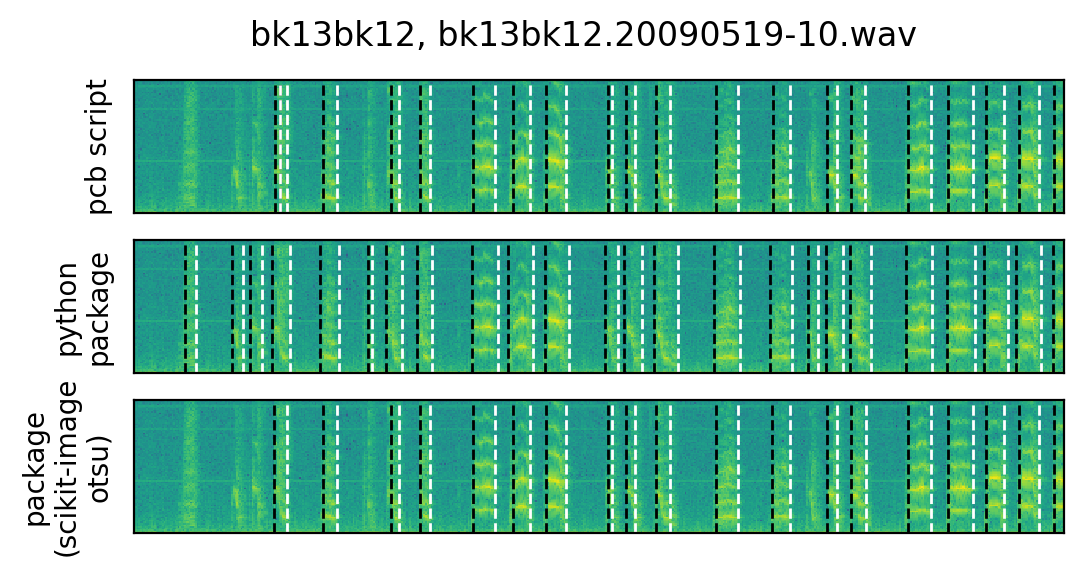

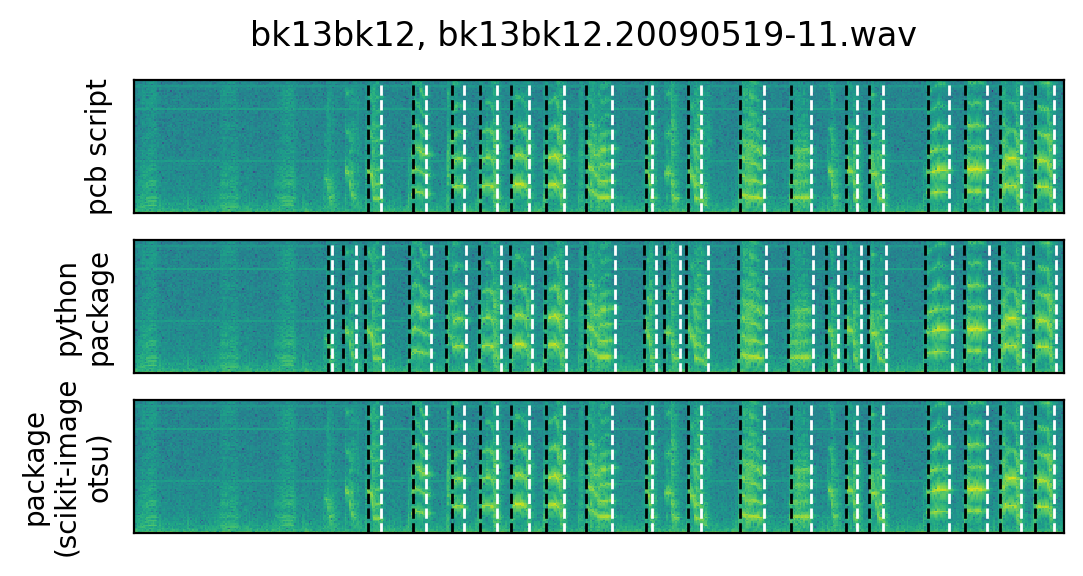

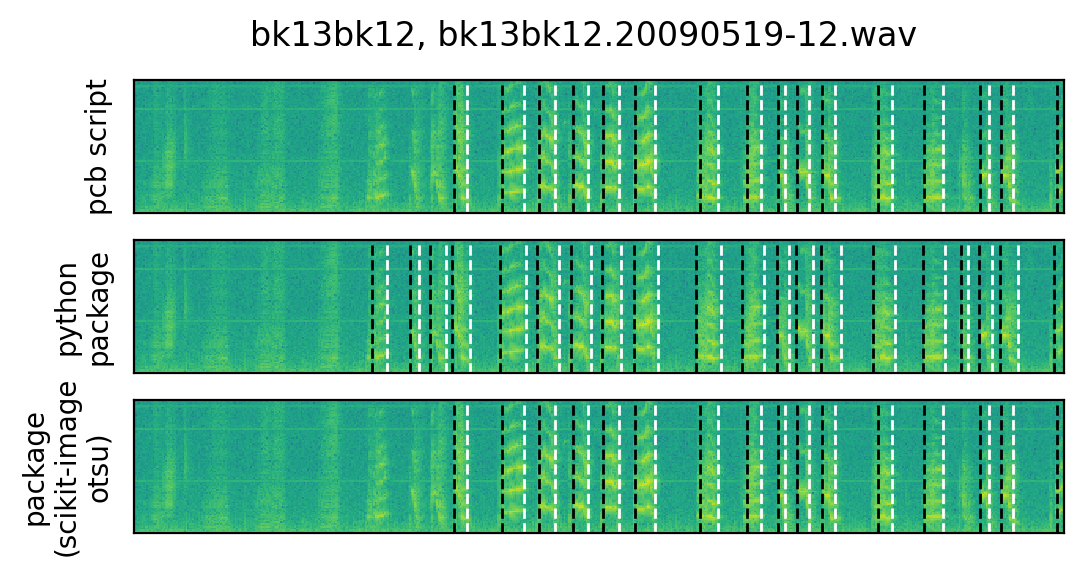

In [9]:
bird_dir = SONG_DATA_ROOT / bird_id

script_csv_path = f'./tests/data-for-tests/generated/{bird_id}-pcb-script-slices.csv'
py_pkg_csv_path = f'./tests/data-for-tests/generated/{bird_id}-py-pkg-slices.csv'
otsu_csv_path = f'./tests/data-for-tests/generated/{bird_id}-py-pkg-skimage-otsu-slices.csv'
script_df = pd.read_csv(script_csv_path)
py_pkg_df = pd.read_csv(py_pkg_csv_path)
otsu_df = pd.read_csv(otsu_csv_path)
for df in (script_df, py_pkg_df, otsu_df):
    df.rename(columns={'# filenum': 'filenum'}, inplace=True)
# fix column so it's just file name
py_pkg_df['filename'] = py_pkg_df['filename'].map(lambda fname: fname.split('/')[-1])
otsu_df['filename'] = otsu_df['filename'].map(lambda fname: fname.split('/')[-1])

wav_paths = sorted(bird_dir.glob('*.wav'))
for tlim, wav_path in zip(tlims, wav_paths):
    sample_rate, samples = wavfile.read(wav_path)
    frequencies, times, spectrogram = make_spec(samples, sample_rate)

    fig, ax_arr = plt.subplots(3, 1, dpi=200, figsize=(6, 3))
    ax_arr = ax_arr.ravel()

    fig.suptitle(f'{bird_id}, {wav_path.name}')

    for ax, df, label in zip(ax_arr, (script_df, py_pkg_df, otsu_df), 
                             ('pcb script', 'python\npackage', 'package\n(scikit-image\notsu)')):
        df_for_segments = df[df.filename == wav_path.name].copy()
        onsets = df_for_segments.start.values / sample_rate
        offsets = df_for_segments.stop.values / sample_rate

        plot_spec(frequencies, times, spectrogram, ax=ax, tlim=tlim)
        ax.set_ylim([0, 15000])
        # ax.set_ylabel('Freq [Hz]')
        ax.set_ylabel(label)
        ax.set_xticks([])
        ax.set_yticks([])

        plot_segments(ax, onsets, offsets)

In [10]:
df_all = []
for df, source in zip(
    (script_df, py_pkg_df, otsu_df),
    ('pcb script', 'py package', 'package (otsu)')
):
    df_copy = df.copy()
    df_copy['source'] = source
    df_all.append(df_copy)
df_all = pd.concat(df_all)

In [11]:
out = df_all.groupby(['source', 'filename']).size()
out = out.reset_index()
out.rename(columns={0: 'num. segments'}, inplace=True)

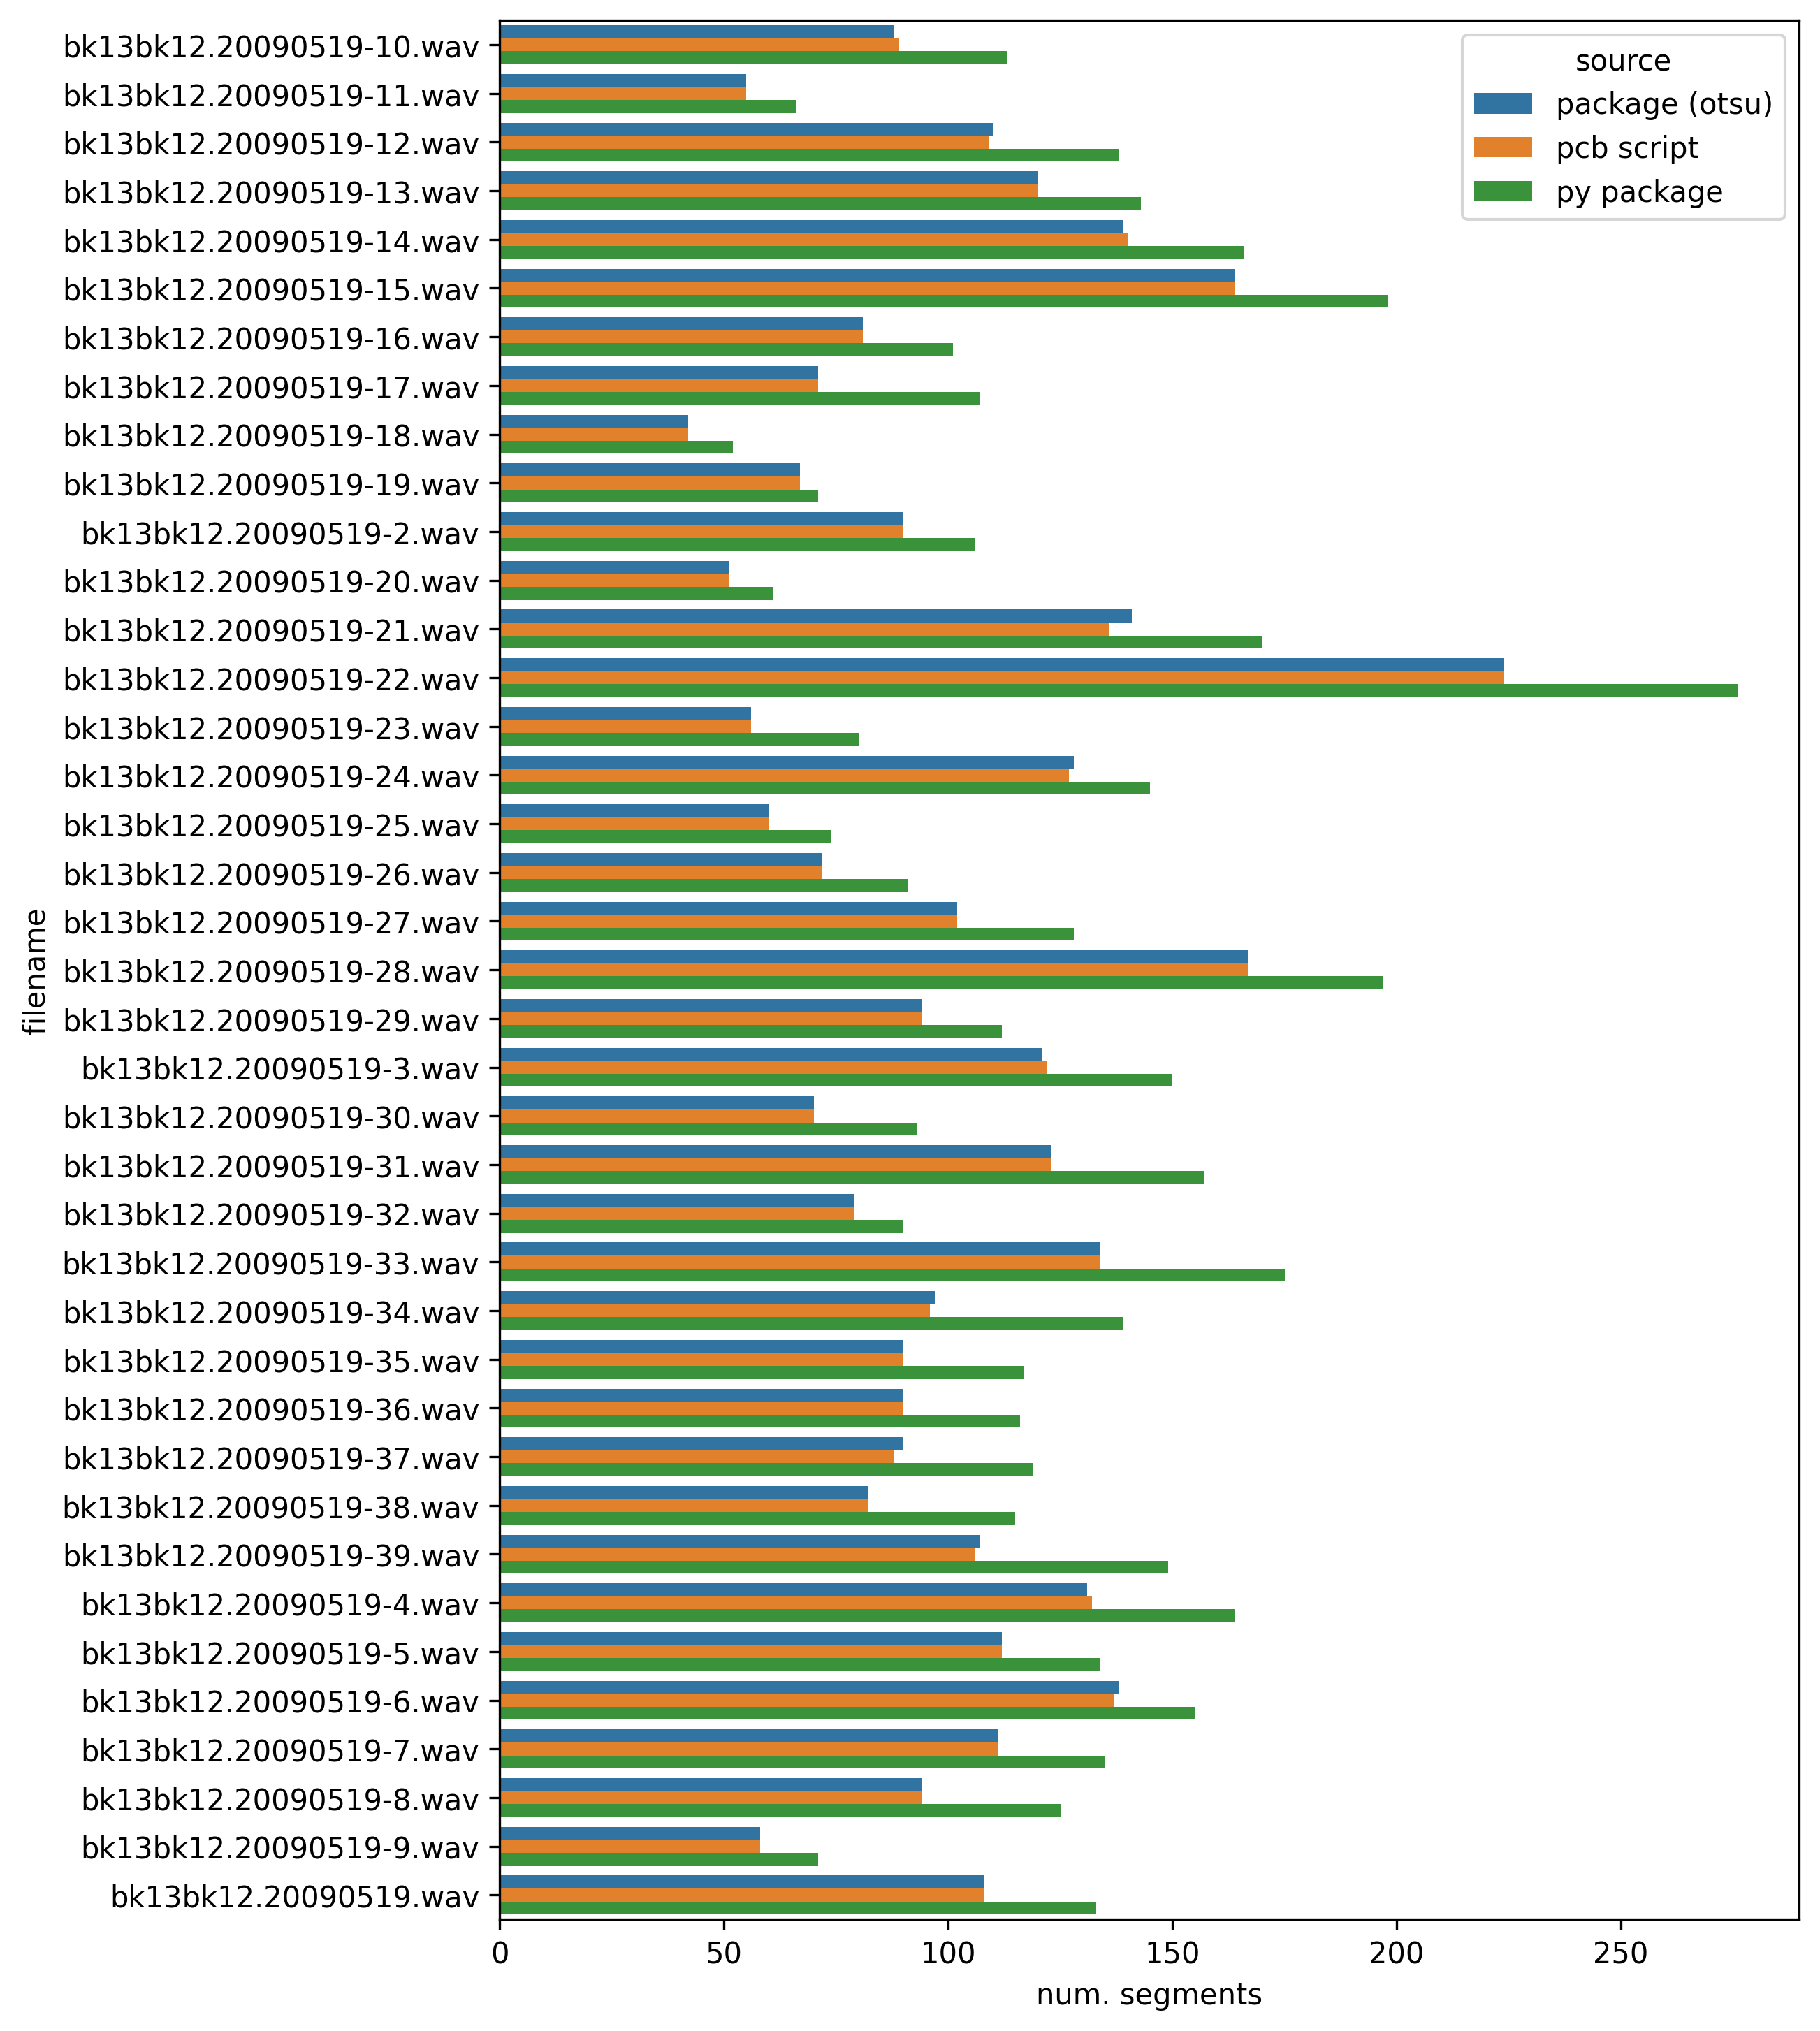

In [12]:
fig, ax = plt.subplots(figsize=(8, 12), dpi=300)

g = sns.barplot(
    data=out,
    y='filename',
    x='num. segments',
    hue='source',
    ax=ax,
    orient='h',
)
